# REFORCEMENT LEARNING

1. REFORCEMENT LEARNING
    2. Q-Learning
        3. Thiết lập mê cung, khởi tạo Q-learning
        3. Lấy tọa độ điểm Start và Goal từ mê cung
        3. Kiểm tra ô có hợp lệ để di chuyển hay không
        3. Di chuyển tác tử theo hành động đồng thời kiểm tra hành động này có hợp lệ hay không
        3. Tính phần thưởng dựa trên trạng thái hiện tại
        3. Lựa chọn action khám phá (explore) hoặc khai thác (exploit)
        3. Huấn luyện Agent bằng Q-learning qua các episode
        3. Tạo đường đi từ điểm bắt đầu đến đích
    2. RLHF
        3. LOAD DATASET

        3. Supervised Fine-Tuning (SFT) - tinh chỉnh có giám sát.
            4. Import thư viện + load load_dataset.py
            4. Class ChatDataset
            4. Hàm train_sft_model
            4. Hàm main()
            4. Đo perplexity trước RLHF

        3. BERT - REWARD MODEL (BERT REPLACE REWARD MODEL CUSTOM)
          4. Import thư viện
          4. Hàm tạo dữ liệu pairwise
          4. Lớp mô hình BERTRewardModel
          4. Hàm tính pairwise loss
          4. Dataset cho reward model
          4. Tạo DataLoader
          4. Khởi tạo mô hình và optimizer
          4. Hàm huấn luyện model
          4. Hàm lưu mô hình và tokenizer
          4. Main

        3. PPO (BERT REPLACE REWARD MODEL CUSTOM)
          4. load_models_and_optim()
          4. compute_reward
          4. Huấn luyện PPO với reward đã tính
          4. Huấn luyện mô hình bằng PPO trên tập dữ liệu đầu vào (train_data)
          4. Đo perplexity sau RLHF
          4. Đánh giá sinh câu – BLEU, ROUGE, METEOR
          4. TEST SFT MODEL
          4. TEST PPO MODEL

## Q-Learning

- Q-Learning là một thuật toán học tăng cường rời rạc, không yêu cầu mô hình (model-free), dùng để huấn luyện một tác tử (agent) học cách tối ưu hóa hành động trong một môi trường có trạng thái hữu hạn. Trong notebook, Q-learning được áp dụng cho bài toán tìm đường trong mê cung:

- Dưới đây là các bước chính:

### Thiết lập mê cung, khởi tạo Q-learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --BẢN ĐỒ MÊ CUNG (15x15) -
# 0: đường, 1: tường, 2: start, 3: goal
maze = np.array([
    [2,0,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,1,0,0,0,0,0,0,1],
    [1,0,1,1,1,1,0,1,0,1,1,1,1,0,1],
    [1,0,1,0,0,0,0,0,0,0,0,0,1,0,1],
    [1,0,1,0,1,1,1,1,1,1,1,0,1,0,1],
    [1,0,1,0,1,0,0,0,0,0,1,0,1,0,1],
    [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],
    [1,0,1,0,1,0,1,3,1,0,1,0,1,0,1],
    [1,0,1,0,1,0,1,1,1,0,1,0,1,0,1],
    [1,0,1,0,1,0,0,0,0,0,1,0,1,0,1],
    [1,0,1,0,1,0,1,1,1,1,1,0,1,0,1],
    [1,0,1,0,0,0,0,0,0,0,0,0,1,0,1],
    [1,0,1,1,1,1,1,1,1,1,1,1,1,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
])

actions = ['up', 'down', 'left', 'right']
q_table = np.zeros((*maze.shape, len(actions)))
gamma = 0.9 # Phía trước là 1 thì đi lối khác, nếu là 0 thì tiếp tục đi
alpha = 0.7 #Tốc độ học nếu gần hay trước mặt là 1(tường) sẽ học ra được vi trí đó là lối cụt hay có khả năng không có lối thoát, nếu là không thì tiếp tục đi
epsilon = 1.0 # = 1.0 để tác tử hành động ngẫu nhiên
epsilon_decay = 0.995 # giảm epsilon sau mỗi bước để tác tử chuyển dần từ khám phá sang khai thác, nếu 1-epsilon thì Agent sẽ khai thác tại vị trí đó luôn (tức loát thoát))
min_epsilon = 0.01 # Epsilon không thể về 0 được luôn có một chút khám phá.
episodes = 5000 # 5000 lần thử đi từ điểm start đến lối thoát hoặc bị kẹt



### Lấy tọa độ điểm Start và Goal từ mê cung

In [ ]:
# Hàm này xác định toạ độ 2(bắt đầu) và 3 (kết thúc)
def get_start_goal():
    start = tuple(map(int, np.argwhere(maze == 2)[0]))
    goal = tuple(map(int, np.argwhere(maze == 3)[0]))
    return start, goal

### Kiểm tra ô có hợp lệ để di chuyển hay không

In [ ]:
def is_valid(state):
    r, c = state
    return 0 <= r < maze.shape[0] and 0 <= c < maze.shape[1] and maze[r][c] != 1



### Di chuyển tác tử theo hành động đồng thời kiểm tra hành động này có hợp lệ hay không

In [ ]:
def take_action(state, action):
    r, c = state
    if action == 'left':
        next_state = (r - 1, c)
    elif action == 'right': # right
        next_state = (r + 1, c)
    elif action == 'up': #up
        next_state = (r, c - 1)
    elif action == 'down': #down
        next_state = (r, c + 1)
    return next_state if is_valid(next_state) else state


### Tính phần thưởng dựa trên trạng thái hiện tại

In [ ]:
def get_reward(state):
    if maze[state] == 3:
        return 10 # Nếu là đích là trả về 10
    elif maze[state] == 1:
        return -1 #nếu là tường trả về -1
    else:
        return -0.1 # nếu là lối đi -0.1

# -0.1 tiếp tục đi, -1 thay đổi hướng khác


### Lựa chọn action khám phá (explore) hoặc khai thác (exploit)
- Exploration vs Exploitation: Chọn hành động ngẫu nhiên (exploration) hoặc theo Q-value tối ưu (exploitation) với xác suất ε-greedy.

In [ ]:
def choose_action(state):
    if random.uniform(0,1) < epsilon:
        return random.choice(range(len(actions)))
    else:
        return np.argmax(q_table[state[0], state[1]])

start, goal = get_start_goal()


# chọn số ngẫu nhiên nếu số này nhỏ hơn epsilon thì hành động có điểm Q cao nhất (-0.1 nếu đi vào đường, -1 nếu đụng tường, +10 nếu về đích)
# nếu lớn hơn epsilon thì đứng yên

### Huấn luyện Agent bằng Q-learning qua các episode


In [ ]:
# === METRICS EVALUATION ===
success_count = 0
steps_list = []
reward_list = []

epsilon_eval = 1.0  # không ảnh hưởng huấn luyện
for episode in range(episodes):
    state = start
    step = 0
    total_reward = 0
    success = False

    while state != goal and step < 300:
        action_index = choose_action(state)
        next_state = take_action(state, actions[action_index])
        reward = get_reward(next_state)

        old_q = q_table[state + (action_index,)]
        next_max = np.max(q_table[next_state])
        q_table[state + (action_index,)] = old_q + alpha * (reward + gamma * next_max - old_q)

        state = next_state
        total_reward += reward
        step += 1

        if state == goal:
            success = True

    if success:
        success_count += 1
        steps_list.append(step)
    reward_list.append(total_reward)

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# === IN HIỂN THỊ CHỈ SỐ ===
print("=== EVALUATION METRICS ===")
print(f"Success Rate: {success_count / episodes:.2f}")
print(f"Average Steps (successful episodes): {np.mean(steps_list) if steps_list else 'N/A'}")
print(f"Average Reward per Episode: {np.mean(reward_list):.2f}")


=== EVALUATION METRICS ===
Success Rate: 0.99
Average Steps (successful episodes): 34.41331175399555
Average Reward per Episode: 6.24


### Tạo đường đi từ điểm bắt đầu đến đích

Đường đi tối ưu đã được tìm thấy.


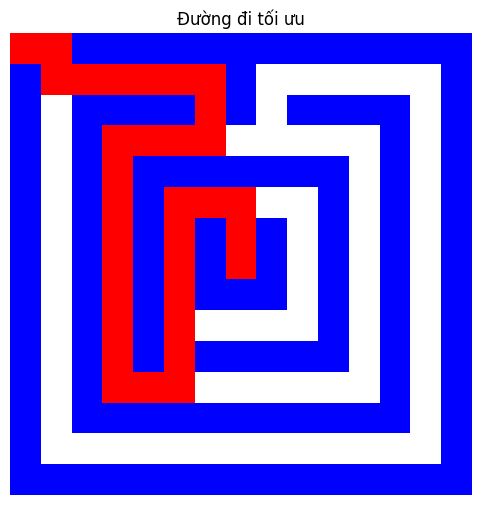

In [ ]:
state = start
path = [state]
visited = set()
while state != goal:
    action_index = np.argmax(q_table[state])
    next_state = take_action(state, actions[action_index])
    if next_state == state or next_state in visited:  # stuck
        print("Robot không thể tìm được đường đi đến đích!")
        break
    path.append(next_state)
    visited.add(state)
    state = next_state

if state == goal:
    print("Đường đi tối ưu đã được tìm thấy.")
else:
    print("Không thể đến được đích.")

final_maze = maze.copy()
for r, c in path:
    final_maze[r, c] = 5

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


colors = ['white', 'black', 'blue', 'red']
cmap = ListedColormap(colors)

display_maze = final_maze.copy()
display_maze[display_maze == 5] = 2

plt.figure(figsize=(6,6))
plt.imshow(display_maze, cmap=cmap, interpolation='nearest')
plt.title("Đường đi tối ưu")
plt.axis('off')
plt.show()



## RLHF

### Thiết lập môi trường và import thư viện cần thiết

In [ ]:
!pip install transformers==4.51.3 datasets==3.5.1 accelerate==1.6.0 trl==0.17.0 peft==0.15.2 evaluate rouge_score nltk
!pip install datasets --upgrade

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00

### LOAD DATASET
- movie_lines.txt
- movie_conversations.txt

In [ ]:
%%writefile load_dataset.py
import os
import ast
import pandas as pd

def load_lines(file_path):
    id2line = {}
    with open(file_path, encoding='iso-8859-1') as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 5:
                id2line[parts[0]] = parts[4]
    return id2line

def load_conversations(file_path):
    conversations = []
    with open(file_path, encoding='iso-8859-1') as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            conv_ids = ast.literal_eval(parts[-1])
            conversations.append(conv_ids)
    return conversations

def build_prompt_response_pairs(id2line, conversations, context_size=2):
    pairs = []
    for conv in conversations:
        for i in range(context_size, len(conv)):
            if all(cid in id2line for cid in conv[i - context_size : i + 1]):
                prompt = " ".join([id2line[conv[j]] for j in range(i - context_size, i)])
                response = id2line[conv[i]]
                pairs.append((prompt, response))
    return pairs

def prepare_train_data(pairs, sample_size=4000):
    train_data = [{"prompt": p, "response": r} for p, r in pairs[:sample_size]]
    df = pd.DataFrame(train_data).dropna().drop_duplicates()
    df = df[df['prompt'].str.len() > 0]
    return df.to_dict(orient="records")

def load_dataset(context_size=2, sample_size=10000):
    id2line = load_lines("movie_lines.txt")
    conversations = load_conversations("movie_conversations.txt")
    pairs = build_prompt_response_pairs(id2line, conversations, context_size=context_size)
    train_data = prepare_train_data(pairs, sample_size=sample_size)
    return train_data


Writing load_dataset.py


## Supervised Fine-Tuning (SFT) - tinh chỉnh có giám sát.

### Import thư viện + load load_dataset.py

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

# Load từ file load_dataset.py
import load_dataset


### Class ChatDataset
- Mã hoá 1 chuỗi gồm "promt + reponse"

In [ ]:
# CLASS ChatDataset
class ChatDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        full_text = item["prompt"] + "\n" + item["response"]
        encoding = self.tokenizer(
            full_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["labels"] = encoding["input_ids"].clone()
        return encoding

# build_prompt_response_pairs trả về pair

### Hàm train_sft_model
- Trả về 1 chuỗi gồm "promt + reponse" được mã hoá

In [ ]:
def train_sft_model(train_data, model_name="distilgpt2", output_dir="./sft_output", num_train_epochs=3):
    os.environ["WANDB_DISABLED"] = "true"

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    train_dataset = ChatDataset(train_data, tokenizer)

    model = AutoModelForCausalLM.from_pretrained(model_name)

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=4,
        num_train_epochs=num_train_epochs,
        logging_steps=10,
        save_steps=500,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()

    model.save_pretrained("sft_model_manual")
    tokenizer.save_pretrained("sft_model_manual")

    return train_dataset


### Hàm main()

In [ ]:
def main():
    train_data = load_dataset.load_dataset(context_size=2, sample_size=5000)
    train_dataset = train_sft_model(train_data)
    return train_dataset

In [ ]:
train_dataset = main()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-be41cc72b8a4>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,9.421400
20,1.006500
30,0.781000
40,0.734600
50,0.647700
60,0.736100
70,0.660900
80,0.614200
90,0.625400
100,0.793300


## BERT - REWARD MODEL (BERT REPLACE REWARD MODEL CUSTOM)

###  Import thư viện

In [ ]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel


### Hàm tạo dữ liệu pairwise
- input train_data promt , reponse1; promt , reponse2,...
- Output: pairwise_data (promt, chosen và reject,...) tướng ứng rp1 ,rp2

In [ ]:
# 4. generate_pairwise_samples.py
import random

def generate_pairwise_samples(data, num_prompts=2000):
    """
    data: list of dicts hoặc DataFrame với các keys: "prompt", "response"
    """
    pairwise_data = []
    prompts = list({item["prompt"] for item in data})[:num_prompts]

    for prompt in prompts:
        # Lấy tất cả responses cho prompt này
        responses = [d["response"] for d in data if d["prompt"] == prompt]
        if not responses:
            continue

        # Chọn 1 câu làm chosen, tự tạo rejected bằng shuffle tokens
        chosen = random.choice(responses)
        tokens = chosen.split()
        random.shuffle(tokens)
        rejected = " ".join(tokens)

        pairwise_data.append({
            "prompt": prompt,
            "chosen": chosen,
            "rejected": rejected
        })

    return pairwise_data

# train data = promt + reponse
# train datasset = promt + reponse mã hoá

            # "prompt": prompt, A
            # "chosen": chosen, B
            # "rejected": rejected C

### Lớp mô hình BERTRewardModel
- Tính rewward value

In [ ]:
class BERTRewardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.value_head = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        reward = self.value_head(cls_output)
        return reward.squeeze(-1)


### Hàm tính pairwise loss
-Tính loss value

In [ ]:
def pairwise_loss(chosen_reward, rejected_reward):
    return -torch.nn.functional.logsigmoid(chosen_reward - rejected_reward).mean()


### Dataset cho reward model
- chosen_text = item["prompt"] + " " + item["chosen"]
- rejected_text = item["prompt"] + " " + item["rejected"]

- Trả về:
  - "chosen_input_ids": chosen_encoding["input_ids"].squeeze(),
  - "chosen_attention_mask": chosen_encoding["attention_mask"].squeeze(), phân biệt token thật và padding token vô nghĩa.
  - "rejected_input_ids": rejected_encoding["input_ids"].squeeze(),
  - "rejected_attention_mask": rejected_encoding["attention_mask"].squeeze() phân biệt token thật và padding token vô nghĩa.

In [ ]:
class RewardDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        chosen_text = item["prompt"] + " " + item["chosen"]
        rejected_text = item["prompt"] + " " + item["rejected"]

        chosen_encoding = self.tokenizer(
            chosen_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        rejected_encoding = self.tokenizer(
            rejected_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "chosen_input_ids": chosen_encoding["input_ids"].squeeze(),
            "chosen_attention_mask": chosen_encoding["attention_mask"].squeeze(),
            "rejected_input_ids": rejected_encoding["input_ids"].squeeze(),
            "rejected_attention_mask": rejected_encoding["attention_mask"].squeeze()
        }



### Tạo DataLoader
- Trả về pairwise_data được mã hoá và trong dataset

In [ ]:
def create_dataloader(pairwise_data, tokenizer, batch_size=2):
    dataset = RewardDataset(pairwise_data, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Khởi tạo mô hình và optimizer
- Trả về một mô hình đánh giá reward dựa trên BERT
- Trả về hàm optimi là Adam

In [ ]:
# 2. initialize_model_and_optimizer.py
# from transformers import AdamW # Remove this line
from torch.optim import AdamW # Import AdamW from torch.optim

def initialize_model_and_optimizer():
    model = BERTRewardModel()
    # Giảm lr xuống 1e-5 để fine-tune BERT ổn định hơn
    optimizer = AdamW(model.parameters(), lr=1e-5)
    return model, optimizer

###  Hàm huấn luyện model
- Input:
  - model tính reward (bert)
  - hàm tối ưu adam
  - loader = Dataset chứa các batch dữ liệu gồm (prompt + chosen, rejected) được mã hoá.
  - Thiết bị đang chạy alf GPU

In [ ]:
# 3. train_model.py
import torch
import torch.nn.functional as F

def train_model(model, optimizer, loader, device):
    model.train()
    for batch in loader:
        # 1) Move tensors to device
        c_ids   = batch["chosen_input_ids"].to(device)
        c_mask  = batch["chosen_attention_mask"].to(device)
        r_ids   = batch["rejected_input_ids"].to(device)
        r_mask  = batch["rejected_attention_mask"].to(device)

        # 2) Zero gradients
        optimizer.zero_grad()

        # 3) Forward
        reward_chosen  = model(c_ids, c_mask)
        reward_rejected = model(r_ids, r_mask)

        # 4) Compute loss với margin nhỏ để ổn định
        target = torch.ones_like(reward_chosen, device=device)
        loss = F.margin_ranking_loss(reward_chosen, reward_rejected, target, margin=0.1)

        # 5) Backward & step
        loss.backward()
        optimizer.step()


### Hàm lưu mô hình và tokenizer

In [ ]:
def save_model_and_tokenizer(reward_model, reward_tokenizer):
    torch.save(reward_model.state_dict(), "bert_reward_model.pt")
    reward_tokenizer.save_pretrained("bert_reward_model")


### Main

In [ ]:
# 1. main.py
def main():
    # 1. Load trực tiếp train_data (list of dicts)
    train_data = load_dataset.load_dataset(context_size=2, sample_size=5000)

    # 2. Sinh pairwise_data ngay từ list
    pairwise_data = generate_pairwise_samples(train_data, num_prompts=2000)

    # 3. Tiếp tục pipeline như cũ
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    loader = create_dataloader(pairwise_data, tokenizer)

    # 4. Khởi tạo model, optimizer và device
    reward_model, optimizer = initialize_model_and_optimizer()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reward_model.to(device)

    # 5. Train và lưu
    train_model(reward_model, optimizer, loader, device)
    save_model_and_tokenizer(reward_model, tokenizer)


if __name__ == "__main__":
    main()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## PPO (BERT REPLACE REWARD MODEL CUSTOM)

###  Dùng BERTRewardModel để đánh giá phản hồi

- Sử dụng mô hình BERT như một encoder để hiểu được cặp prompt-response và đánh giá mức độ "tốt" của nó thông qua một value head.

- Reward được tính dựa trên token [CLS] vì nó đại diện cho toàn bộ câu.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizer, BertModel


# Define Reward Model
class BERTRewardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.value_head = nn.Linear(self.bert.config.hidden_size, 1)  # This was the name used in training

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        reward = self.value_head(cls_output)  # Use the correct head name
        return reward.squeeze(-1)  # (batch_size,)



### Load_models_and_optim()
Trả về:

  - Policy_model: Mô hình GPT đang được huấn luyện. (được PPO cải thiện)
  - policy_tokenizer bộ mã hoá tương ứng với Policy_model.

  - Ref_model: Mô hình tham chiếu cố định, không cập nhật.(SFT ban đầu)

  - Reward_model: BERT đã huấn luyện để đánh giá phản hồi.
  - reward_tokenizer bộ mã hoá của bert

  - Optimizer: SGD/Adam dùng để tối ưu hóa policy.

In [ ]:
# Tải mô hình policy, reference, reward và khởi tạo tokenizer + optimizer.
# Trả về các mô hình và bộ tối ưu hóa để dùng trong huấn luyện PPO.

def load_models_and_optim():
    # Load policy model and tokenizer
    policy_model = AutoModelForCausalLM.from_pretrained("sft_model_manual").cuda()
    policy_model.train()
    policy_tokenizer = AutoTokenizer.from_pretrained("sft_model_manual")

    # Load reference model
    ref_model = AutoModelForCausalLM.from_pretrained("sft_model_manual").cuda()
    ref_model.eval()

    # Load reward model
    reward_model = BERTRewardModel() # Load the same architecture
    reward_model.load_state_dict(torch.load("bert_reward_model.pt")) # Load the trained weights
    reward_model.cuda() # Move to GPU
    reward_model.eval()
    reward_tokenizer = BertTokenizer.from_pretrained("bert_reward_model")

    # Optimizer
    optimizer = optim.Adam(policy_model.parameters(), lr=1e-6)

    return policy_model, policy_tokenizer, ref_model, reward_model, reward_tokenizer, optimizer


### Compute_reward
- Nối prompt + response thành chuỗi đầu vào cho BERT.

- BERT được huấn luyện từ dữ liệu phản hồi có gán nhãn ưu - khuyết (ví dụ: giữa hai câu trả lời khác nhau, cái nào tốt hơn). Nên có thể ước lượng điểm số tuyệt đối cho một phản hồi duy nhất, thay vì luôn cần so sánh hai câu trả lời.



In [ ]:
# Tính điểm thưởng (reward) cho một cặp prompt–response bằng BERT reward model.
def compute_reward(prompt, response, reward_model, reward_tokenizer):
    input_text = prompt + " " + response
    inputs = reward_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.cuda() for k, v in inputs.items() if k in ["input_ids", "attention_mask"]}

    with torch.no_grad():
        reward_score = reward_model(**inputs)
    return reward_score.item()




### Huấn luyện PPO với reward đã tính - Thuật toán PPO cập nhật mô hình
- Cập nhật mô hình policy_model bằng cách:

  - So sánh logits của policy_model với ref_model (GPT cũ)

  - Kết hợp với reward từ reward_model

  - Áp dụng KL penalty để tránh policy_model học lệch quá xa

  - Tính loss và cập nhật policy_model

  - Trả về: loss value

In [ ]:
# Cập nhật policy_model bằng cách so sánh với ref_model và reward.
import torch.nn.functional as F

def ppo_step(prompt, response, reward, policy_model, policy_tokenizer, ref_model, optimizer, beta=0.1):
    # Tokenize và chuyển toàn bộ inputs lên GPU
    inputs = policy_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(policy_model.device) for k, v in inputs.items()}  #

    with torch.no_grad():
        ref_outputs = ref_model(**inputs)
        ref_logits = ref_outputs.logits

    outputs = policy_model(**inputs)
    policy_logits = outputs.logits

    # Tính KL divergence
    kl = F.kl_div(
        F.log_softmax(policy_logits, dim=-1),
        F.softmax(ref_logits, dim=-1),
        reduction="batchmean"
    )

    # PPO loss với KL penalty
    loss = -reward + beta * kl
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()





###  Huấn luyện mô hình bằng PPO trên tập dữ liệu đầu vào (train_data).
- Với mỗi prompt:

  - GPT sinh phản hồi.

  - BERT chấm điểm phản hồi.

  - PPO cập nhật policy dựa trên reward.

- Sau mỗi 50 bước, in loss và reward để theo dõi.

In [ ]:
def train_with_ppo(train_data, steps=2000):
    print("Bắt đầu huấn luyện PPO...")
    policy_model, policy_tokenizer, ref_model, reward_model, reward_tokenizer, optimizer = load_models_and_optim()
    print("Mô hình và tokenizer đã được tải.")

    for i, sample in enumerate(train_data[:steps]):
        print(f"Bắt đầu bước {i}")
        prompt = sample["prompt"]

        try:
            inputs = policy_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=256)
            input_ids = inputs["input_ids"].cuda()
            attention_mask = inputs["attention_mask"].cuda()

            output_ids = policy_model.generate(
                input_ids,
                attention_mask=attention_mask,
                pad_token_id=policy_tokenizer.eos_token_id,
                max_new_tokens=256
            )
            response = policy_tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()

            reward = compute_reward(prompt, response, reward_model, reward_tokenizer)
            loss = ppo_step(prompt, response, reward, policy_model, policy_tokenizer, ref_model, optimizer)

            if i % 50 == 0:
                print(f"Step {i} | Loss: {loss:.4f} | Reward: {reward:.4f}")
        except Exception as e:
            print(f"Lỗi ở bước {i}: {e}")
            break

    print("Đang lưu mô hình vào 'ppo_model'...")
    policy_model.save_pretrained("ppo_model")
    policy_tokenizer.save_pretrained("ppo_model")
    print(" Mô hình đã được lưu.")


In [ ]:
# Gọi hàm huấn luyện
train_with_ppo(train_dataset.data[:2000])

# Kiểm tra mô hình đã lưu chưa
import os
print("ppo_model exists:", os.path.exists("ppo_model"))


Bắt đầu huấn luyện PPO...
Mô hình và tokenizer đã được tải.
Bắt đầu bước 0
Step 0 | Loss: 0.6986 | Reward: 0.1362
Bắt đầu bước 1
Bắt đầu bước 2
Bắt đầu bước 3
Bắt đầu bước 4
Bắt đầu bước 5
Bắt đầu bước 6
Bắt đầu bước 7
Bắt đầu bước 8
Bắt đầu bước 9
Bắt đầu bước 10
Bắt đầu bước 11
Bắt đầu bước 12
Bắt đầu bước 13
Bắt đầu bước 14
Bắt đầu bước 15
Bắt đầu bước 16
Bắt đầu bước 17
Bắt đầu bước 18
Bắt đầu bước 19
Bắt đầu bước 20
Bắt đầu bước 21
Bắt đầu bước 22
Bắt đầu bước 23
Bắt đầu bước 24
Bắt đầu bước 25
Bắt đầu bước 26
Bắt đầu bước 27
Bắt đầu bước 28
Bắt đầu bước 29
Bắt đầu bước 30
Bắt đầu bước 31
Bắt đầu bước 32
Bắt đầu bước 33
Bắt đầu bước 34
Bắt đầu bước 35
Bắt đầu bước 36
Bắt đầu bước 37
Bắt đầu bước 38
Bắt đầu bước 39
Bắt đầu bước 40
Bắt đầu bước 41
Bắt đầu bước 42
Bắt đầu bước 43
Bắt đầu bước 44
Bắt đầu bước 45
Bắt đầu bước 46
Bắt đầu bước 47
Bắt đầu bước 48
Bắt đầu bước 49
Bắt đầu bước 50
Step 50 | Loss: -0.1352 | Reward: 0.4739
Bắt đầu bước 51
Bắt đầu bước 52
Bắt đầu bước 53
Bắt đầ

### Tính reward trung bình cho kết quả RLHF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

So sánh Reward:
- Trước RLHF (SFT): 0.0288
- Sau RLHF       : 0.0553
Chênh lệch    : 0.0265


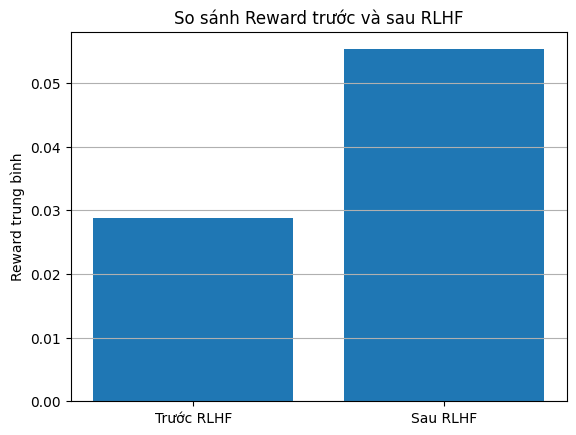

In [ ]:
import torch
import matplotlib.pyplot as plt

# === Hàm sinh phản hồi từ mô hình ===
def generate_responses(prompts, model, tokenizer,
                       max_input_length=128, max_new_tokens=128):
    model.eval()
    responses = []
    for prompt in prompts:
        # truncate prompt về max_input_length
        inputs = tokenizer(prompt,
                           return_tensors="pt",
                           truncation=True,
                           max_length=max_input_length
                          ).to(model.device)
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id  # nếu cần
            )
        responses.append(
            tokenizer.decode(output[0], skip_special_tokens=True)
        )
    return responses


# === Bước 1: Load mô hình và tokenizer ===
policy_model, policy_tokenizer, ref_model, reward_model, reward_tokenizer, optimizer = load_models_and_optim()



prompts = [item["prompt"] for item in load_dataset.load_dataset(context_size=2, sample_size=100)]

# === Bước 3: Sinh câu trả lời trước RLHF (SFT/ref_model) ===
preds_sft = generate_responses(prompts, ref_model, reward_tokenizer)

# === Bước 4: Tính reward trung bình trước RLHF ===
rewards_sft = [
    compute_reward(prompt, pred, reward_model, reward_tokenizer)
    for prompt, pred in zip(prompts, preds_sft)
]
avg_reward_sft = sum(rewards_sft) / len(rewards_sft)

# === Bước 5: Sinh câu trả lời sau RLHF (policy_model) ===
preds_rlhf = generate_responses(prompts, policy_model, reward_tokenizer)

# === Bước 6: Tính reward trung bình sau RLHF ===
rewards_rlhf = [
    compute_reward(prompt, pred, reward_model, reward_tokenizer)
    for prompt, pred in zip(prompts, preds_rlhf)
]
avg_reward_rlhf = sum(rewards_rlhf) / len(rewards_rlhf)

# === Bước 7: In kết quả so sánh ===
print(f"So sánh Reward:")
print(f"- Trước RLHF (SFT): {avg_reward_sft:.4f}")
print(f"- Sau RLHF       : {avg_reward_rlhf:.4f}")
print(f"Chênh lệch    : {avg_reward_rlhf - avg_reward_sft:.4f}")

# === Bước 8: Vẽ biểu đồ so sánh ===
plt.bar(["Trước RLHF", "Sau RLHF"], [avg_reward_sft, avg_reward_rlhf])
plt.ylabel("Reward trung bình")
plt.title("So sánh Reward trước và sau RLHF")
plt.grid(True, axis='y')
plt.show()


### Đánh giá bằng BLUE và ROUGE

In [ ]:
import re
import evaluate

# === Load metrics BLEU / ROUGE ===
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# === Hàm tiền xử lý text ===
def clean_text(text):
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

# === Hàm tính BLEU / ROUGE với tiền xử lý ===
def compute_bleu_rouge(preds, refs):
    preds = [clean_text(" ".join(p)) if isinstance(p, list) else clean_text(p) for p in preds]
    refs = [[clean_text(r) for r in group] for group in refs]  # refs: List[List[str]]

    refs_tokenized = [[r.split()] for r in [group[0] for group in refs]]  # chỉ lấy 1 reference

    bleu = bleu_metric.compute(
        predictions=preds,
        references=refs_tokenized
    )

    rouge = rouge_metric.compute(
        predictions=preds,
        references=[group[0] for group in refs]
    )

    # Nếu rouge trả về scalar, dùng trực tiếp
    return bleu["bleu"], rouge["rouge1"], rouge["rouge2"], rouge["rougeL"]



In [ ]:
# === Load mô hình ===
policy_model, policy_tokenizer, ref_model, reward_model, reward_tokenizer, optimizer = load_models_and_optim()

prompts = [
    "What is the capital of France?",
    "Explain what a black hole is.",
    "How do I bake a chocolate cake?",
    "Who was Albert Einstein?",
    "What is the meaning of life?",
    "What causes rain?",
    "How do airplanes fly?",
    "Define photosynthesis.",
    "Who wrote 'Romeo and Juliet'?",
    "What is the Pythagorean theorem?",
    "What is the speed of light in a vacuum?",
    "What is the chemical formula of water?",
    "Who developed the theory of evolution by natural selection?",
    "What is the powerhouse of the cell?",
    "What causes tides on Earth?"

]

references = [
    "The capital of France is Paris.",
    "A black hole is a region of space where gravity is so strong that nothing can escape.",
    "To bake a chocolate cake, mix flour, sugar, eggs, cocoa powder, and bake it.",
    "Albert Einstein was a theoretical physicist known for the theory of relativity.",
    "The meaning of life is subjective and varies from person to person.",
    "Rain is caused by condensed water vapor falling from clouds.",
    "Airplanes fly using the principles of lift, thrust, drag, and weight.",
    "Photosynthesis is the process by which plants convert sunlight into energy.",
    "'Romeo and Juliet' was written by William Shakespeare.",
    "The Pythagorean theorem states that a² + b² = c² in a right triangle.",
    "The speed of light in a vacuum is approximately 299,792 kilometers per second.",
    "The chemical formula of water is H2O.",
    "Charles Darwin developed the theory of evolution by natural selection.",
    "The mitochondrion is the powerhouse of the cell.",
    "Tides on Earth are caused by the gravitational pull of the Moon and the Sun."
]


# === Sinh phản hồi
preds_sft = generate_responses(prompts, ref_model, reward_tokenizer)
preds_rlhf = generate_responses(prompts, policy_model, reward_tokenizer)

# === BLEU / ROUGE (đã có tiền xử lý)
bleu_sft, rouge1_sft, rouge2_sft, rougeL_sft = compute_bleu_rouge(preds_sft, references)
bleu_rlhf, rouge1_rlhf, rouge2_rlhf, rougeL_rlhf = compute_bleu_rouge(preds_rlhf, references)

# === In kết quả
print("So sánh BLEU / ROUGE:")
print(f"BLEU    : SFT = {bleu_sft:.4f} | RLHF = {bleu_rlhf:.4f}")
print(f"ROUGE-1 : SFT = {rouge1_sft:.4f} | RLHF = {rouge1_rlhf:.4f}")
print(f"ROUGE-2 : SFT = {rouge2_sft:.4f} | RLHF = {rouge2_rlhf:.4f}")
print(f"ROUGE-L : SFT = {rougeL_sft:.4f} | RLHF = {rougeL_rlhf:.4f}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

So sánh BLEU / ROUGE:
BLEU    : SFT = 0.0000 | RLHF = 0.0000
ROUGE-1 : SFT = 0.0103 | RLHF = 0.0190
ROUGE-2 : SFT = 0.0000 | RLHF = 0.0000
ROUGE-L : SFT = 0.0103 | RLHF = 0.0190


#### TEST SFT MODEL

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load mô hình đã fine-tune (SFT)
model_name = "sft_model_manual"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).cuda()  # Load model to cuda

# Prompt mới để test
test_prompt = "Say something funny!"

# Tokenize và sinh response từ mô hình đã fine-tune
# Move input_ids to cuda
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids.cuda()

# Sinh văn bản với các tham số kiểm soát sự lặp lại
output_ids = model.generate(
    input_ids,
    max_length=512,  # Giới hạn độ dài văn bản sinh
    repetition_penalty=2.0,  # Phạt việc lặp lại từ
    top_p=0.95,  # Nucleus sampling
    top_k=50,  # Giới hạn top k từ lựa chọn
    no_repeat_ngram_size=2,  # Không lặp lại n-gram size 2
    eos_token_id=tokenizer.eos_token_id  # Token EOS để dừng sinh văn bản
)

# Chuyển output_ids thành text
generated_response = tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(test_prompt, "").strip()

print(f"Test Prompt: {test_prompt}")
print(f"SFT Model Response: {generated_response}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Test Prompt: Say something funny!
SFT Model Response: I'm sorry, but it's not a joke.
I don't know what you're talking about...


#### TEST PPO MODEL

In [ ]:
import torch

# Lấy ví dụ prompt để test
test_prompts = ["Say something funny!"]

# Load các model và tokenizer cần thiết (đảm bảo đã chạy cell định nghĩa hàm load_models_and_optim trước đó)
policy_model, policy_tokenizer, ref_model, reward_model, reward_tokenizer, optimizer = load_models_and_optim()

# Lặp qua các prompt để kiểm tra PPO
for prompt in test_prompts:
    # Sinh response từ policy model
    input_ids = policy_tokenizer(prompt, return_tensors="pt").input_ids.cuda()

    # Cài đặt các tham số sinh văn bản để tránh lặp lại và kiểm soát sự đa dạng
    output_ids = policy_model.generate(
        input_ids,
        max_length=512,  # Độ dài tối đa của văn bản sinh
        top_k=50,  # Chỉ giữ lại top 50 lựa chọn từ
        top_p=0.95,  # Dùng nucleus sampling với p=0.95
        repetition_penalty=2.0,  # Phạt việc lặp lại từ
        eos_token_id=policy_tokenizer.eos_token_id,  # Dùng token EOS để dừng khi cần
        no_repeat_ngram_size=2  # Không lặp lại n-gram có kích thước 2
    )

    generated_response = policy_tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()

    # Tính reward từ reward model
    reward = compute_reward(prompt, generated_response, reward_model, reward_tokenizer)

    # Tiến hành PPO update
    loss = ppo_step(prompt, generated_response, reward, policy_model, policy_tokenizer, ref_model, optimizer)

    # In kết quả
    print(f"Prompt: {prompt}")
    print(f"Generated Response: {generated_response}")
    print(f"Reward: {reward:.4f}")
    print(f"Loss: {loss:.4f}\n")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Say something funny!
Generated Response: I'm not a big fan of that kind.
I don't want to be silly, but you're the best at it
Reward: 0.4640
Loss: -0.4104

